In [1]:
from models import LeNet
from models_structured import PrunedLeNet
import numpy as np
import torch 


from models import CancerNet_fc, LeNet, ResNet
from datasets_custom import CancerDataset, RotatedMNIST
from torch.nn.utils import prune
import torchvision.transforms as transforms
from laplace import Laplace 
from laplace import KronLaplace, DiagLaplace
import torch
import time 
from utils import evaluate_classification
from marglikopt import marglik_optimization
import os
import wandb
from utils import evaluate_classification

In [2]:
cfg = {}

In [487]:
train_dataset = RotatedMNIST(root='./data', degree=0, train=True, download=True, transform=transforms.ToTensor())
valid_dataset = RotatedMNIST(root='data', degree=0, train=False, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [488]:


def config_Wb(runname):
    unique_id = wandb.util.generate_id()
    
    wandb.init(id = unique_id, name=runname, project=self.config['wandb']['project'], entity=self.config['wandb']['entity'], config=to_log)
        
        
def get_unpruned_filter_indices(conv_layer):
    weights = conv_layer.weight.data.cpu().numpy()
    unpruned = np.any(weights != 0, axis=(1, 2, 3))  
    return np.nonzero(unpruned)[0]

def copy_weights(structured_zero_model, new_model, unpruned_indices):
    
    orig_layer = getattr(structured_zero_model, 'conv1')
    new_layer = getattr(new_model, 'conv1')
    indices = unpruned_indices['conv1']
    new_layer.weight.data = orig_layer.weight.data[indices, :, :, :]
    if orig_layer.bias is not None:
        new_layer.bias.data = orig_layer.bias.data[indices]

    
    for layer_name in ['conv2', 'conv3']:
        orig_layer = getattr(structured_zero_model, layer_name)
        new_layer = getattr(new_model, layer_name)
        out_indices = unpruned_indices[layer_name]

        
        if layer_name == 'conv2':
            in_indices = unpruned_indices['conv1']
        elif layer_name == 'conv3':
            in_indices = unpruned_indices['conv2']

        
        new_layer.weight.data = orig_layer.weight.data[out_indices, :, :, :][:, in_indices, :, :]
        if orig_layer.bias is not None:
            new_layer.bias.data = orig_layer.bias.data[out_indices]
            
    return new_model


In [489]:
structured_zero_model = LeNet(n_out=10)
dir_zeromod = '/nfs/xxxxxx/pattern/LeNet_mnist_KronLaplace_diagonal_100_wp_struct'
removed_strture = dir_zeromod + '/removed_structure_new'
os.makedirs(removed_strture,exist_ok = True)
models = [f for f in os.listdir(dir_zeromod) if f.endswith('.pt')]
# filter so we t

In [490]:
print(len(models))

11


In [491]:
for i in models:
    print(i)

LeNet_mnist_KronLaplace_diagonal_100_wp_baseline_acc0.9720997214317322_marg_0.19024167954921722.pt
LeNet_mnist_KronLaplace_diagonal_100_wp_acc0.9720997214317322_marg_0.1708349883556366_sparsity_20_maskaftereach.pt
LeNet_mnist_KronLaplace_diagonal_100_wp_acc0.9720997214317322_marg_0.27946019172668457_sparsity_90_maskaftereach.pt
LeNet_mnist_KronLaplace_diagonal_100_wp_acc0.9720997214317322_marg_0.16348254680633545_sparsity_70_maskaftereach.pt
LeNet_mnist_KronLaplace_diagonal_100_wp_acc0.9720997214317322_marg_0.7630780935287476_sparsity_95_maskaftereach.pt
LeNet_mnist_KronLaplace_diagonal_100_wp_acc0.9720997214317322_marg_0.1665884554386139_sparsity_80_maskaftereach.pt
LeNet_mnist_KronLaplace_diagonal_100_wp_acc0.9720997214317322_marg_0.17605504393577576_sparsity_75_maskaftereach.pt
LeNet_mnist_KronLaplace_diagonal_100_wp_acc0.9720997214317322_marg_1.5958958864212036_sparsity_99_maskaftereach.pt
LeNet_mnist_KronLaplace_diagonal_100_wp_acc0.9720997214317322_marg_0.20665955543518066_sparsi

In [492]:
def run_timed_inference(model, input_shape, batch_sizes, device):
    total_time = 0

    # Loop through each batch size
    run_batch = { 'batch_size': batch_sizes, 'time_per_image': [], 'batch_time': []}
    for batch_size in batch_sizes:
        # Create a dummy input tensor with the given input shape and batch size
        dummy_input = torch.randn((batch_size, *input_shape)).to(device)

        # Ensure synchronization before starting the timer
        torch.cuda.synchronize()

        start = time.time()

        # Run the model inference
        model(dummy_input)

        # Synchronize again to ensure accurate timing
        torch.cuda.synchronize()

        end = time.time()
        
        run_batch['time_per_image'].append((end - start)*1000 / batch_size)
        run_batch['batch_time'].append((end - start)*1000)
        
        
        


    

    

    return run_batch

In [493]:
def run_timed_inference(model, input_shape, batch_sizes, device, num_runs=10, warmup_runs=5):
    run_batch = { 'batch_size': batch_sizes, 'time_per_image': [], 'batch_time': []}

    for batch_size in batch_sizes:
        dummy_input = torch.randn((batch_size, *input_shape)).to(device)

        # Warm-up runs
        for _ in range(warmup_runs):
            model(dummy_input)

        #torch.cuda.synchronize()  
        torch.cuda.synchronize()
        start = time.time()
        
        # Multiple runs for averaging
        for _ in range(num_runs):
            model(dummy_input)

        #torch.cuda.synchronize()  # Synchronize after runs
        torch.cuda.synchronize()
        end = time.time()

        total_time = (end - start) * 1000 / num_runs  # Convert to milliseconds
        run_batch['time_per_image'].append(total_time / batch_size)
        run_batch['batch_time'].append(total_time)

    return run_batch

In [494]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [495]:
device = torch.device('cuda:0')

In [496]:
sparsity_values = [] 
batch_time = []
batchsizes = [4,8,16,32,64,128,256,512]
model_size = []
val_ac_lst = []
margliks_lst = []

In [497]:
splits = models[0].split("_")
run_name = "_".join(splits[:4]) + "_compressed_meta"

In [498]:
run_name

'LeNet_mnist_KronLaplace_diagonal_compressed_meta'

In [502]:
unique_id = wandb.util.generate_id()
wandb.init(id = unique_id, name=run_name, project="BNN_Sparse", entity="xxxxxx")

marglik,▁
model_size,▁
sparsity,▁
val_acc,▁
marglik,0.19024
model_size,245991
sparsity,0
val_acc,97.21


In [503]:
wandb_log = True
train = True

In [504]:

for model_name in models:
    if "baseline" in model_name: 
        print("BASELINEEEEEE")
        model_sparsity = 0
        model = LeNet(n_out=10)
        model.load_state_dict(torch.load(os.path.join(dir_zeromod, model_name)))
        device= "cpu"
        model.to(device)
        val_acc = evaluate_classification(model, test_loader)
        run_batch = run_timed_inference(model, test_loader.dataset[0][0].shape, batchsizes, device)
        print(f"Model: {model}, Sparsity: {model_sparsity}, Val Acc: {val_acc}")
        print(run_batch)
        print("-----------")
        sparsity_values.append(int(model_sparsity))
        batch_time.append(run_batch["batch_time"])
        mod_size= os.path.getsize(os.path.join(dir_zeromod, model_name))
        model_size.append(mod_size)
        val_ac_lst.append(val_acc)
        model_iterm = model_name.replace(".pt", "")
        marg = float(model_iterm.split("_")[-1])
        if wandb_log:
            wandb.log({"sparsity": model_sparsity, "val_acc": val_acc,
                        "run_batch": run_batch, "model_size": mod_size,"marglik":marg})
        
        

        
        
        
    else:
        device="cuda:0"
        model_sparsity = int(model_name.split('_')[-2])
        structured_zero_model = LeNet(n_out=10)
        structured_zero_model.load_state_dict(torch.load(os.path.join(dir_zeromod, model_name)))
        structured_zero_model.to(device)
        #val_acc = evaluate_classification(model, test_loader)
        #run_batch = run_timed_inference(structured_zero_model, test_loader.dataset[0][0].shape, [1,2,4,8], device)
        #print(f"Model: {structured_zero_model}, Sparsity: {model_sparsity}, Val Acc: {val_acc}")
        #print(run_batch)
        #print("DELLLLLLLLLLLLLLLLLLETEEEEEEEEEEEEEEEEEEEEEEED STRUUUUUUUUUUUUUUUUUUUUUUCTUREEEEEEEEEEEEEEEEEEEEEEEEEEEE")
        
        unpruned_indices = {
                'conv1': get_unpruned_filter_indices(structured_zero_model.conv1),
                'conv2': get_unpruned_filter_indices(structured_zero_model.conv2),
                'conv3': get_unpruned_filter_indices(structured_zero_model.conv3)
            }

        new_model = PrunedLeNet(
            n_filters_conv1=len(unpruned_indices['conv1']),
            n_filters_conv2=len(unpruned_indices['conv2']),
            n_filters_conv3=len(unpruned_indices['conv3'])
        )

        copy_weights(structured_zero_model, new_model, unpruned_indices)
        new_model.to(device)
        #criterion = torch.nn.CrossEntropyLoss()
        #optimizer = torch.optim.Adam(new_model.parameters(), lr=0.001)
        if train == True:
            la, new_model, margliks, val_perf = marglik_optimization(           
                                        model=new_model, train_loader=train_loader,
                                        valid_loader= test_loader,likelihood="classification",
                                        lr=0.001,
                                        n_epochs=5,
                                        laplace=KronLaplace,
                                        prior_structure="diagonal",
                                        log_wandb = False,
                                )
            val_ac_lst.append(val_perf)
            margliks_lst.append(margliks)


        device = "cpu"
        new_model.to(device)
        run_batch = run_timed_inference(new_model, test_loader.dataset[0][0].shape, batchsizes, device)
        #print(f"Model: {new_model}, Sparsity: {model_sparsity}, Val Acc: {val_acc}")
        
        print(f"Sparsity: {model_sparsity}")
        print(run_batch)
        print("-----------")
        sparsity_values.append(int(model_sparsity))
        batch_time.append(run_batch["batch_time"])
        
        
        # save the model and read its size overwriting the old one if it exists 
        splits = model_name.split("_")
        
        model_name_new = "_".join(splits[:4]) + f"reducued_{model_sparsity}_acc_{val_perf*100}_marg_{margliks[-1]}.pt"
        model_metadata = {
            'n_filters_conv1': len(unpruned_indices['conv1']),
            'n_filters_conv2': len(unpruned_indices['conv2']),
            'n_filters_conv3': len(unpruned_indices['conv3'])
        }
        model_to_save = {
            'state_dict': new_model.state_dict(),
            'metadata': model_metadata
        }
        torch.save(model_to_save, os.path.join(removed_strture, model_name_new))
        mod_size= os.path.getsize(os.path.join(removed_strture, model_name_new))
        model_size.append(mod_size)
        if wandb_log:
            wandb.log({"sparsity": model_sparsity, "val_acc": val_perf*100,
                        "run_batch": run_batch, "model_size": mod_size,"marglik":margliks[-1]})


BASELINEEEEEE
Accuracy of the network 97 %
Model: LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (act3): ReLU()
  (lin1): Linear(in_features=120, out_features=84, bias=True)
  (act4): ReLU()
  (linout): Linear(in_features=84, out_features=10, bias=True)
), Sparsity: 0, Val Acc: 97.21
{'batch_size': [4, 8, 16, 32, 64, 128, 256, 512], 'time_per_image': [0.1092374324798584, 0.06642639636993408, 0.04519373178482056, 0.03402978181838989, 0.028529763221740723, 0.02593994140625, 0.024773087352514267, 0.02361028455197811], 'batch_time': [0.4369497299194336, 0.5314111709594727, 0.7230997085571289, 1.0889530

In [506]:
wandb.finish()

In [507]:
flattened_data = []
for i, sparsity in enumerate(sparsity_values):
    for j, batch_size in enumerate(batchsizes):
        flattened_data.append({
            'Sparsity': sparsity,
            'Batch Size': batch_size,
            'Batch Time': batch_time[i][j]
        })



In [508]:
# Creating a DataFrame from the flattened data
df_flattened = pd.DataFrame(flattened_data)



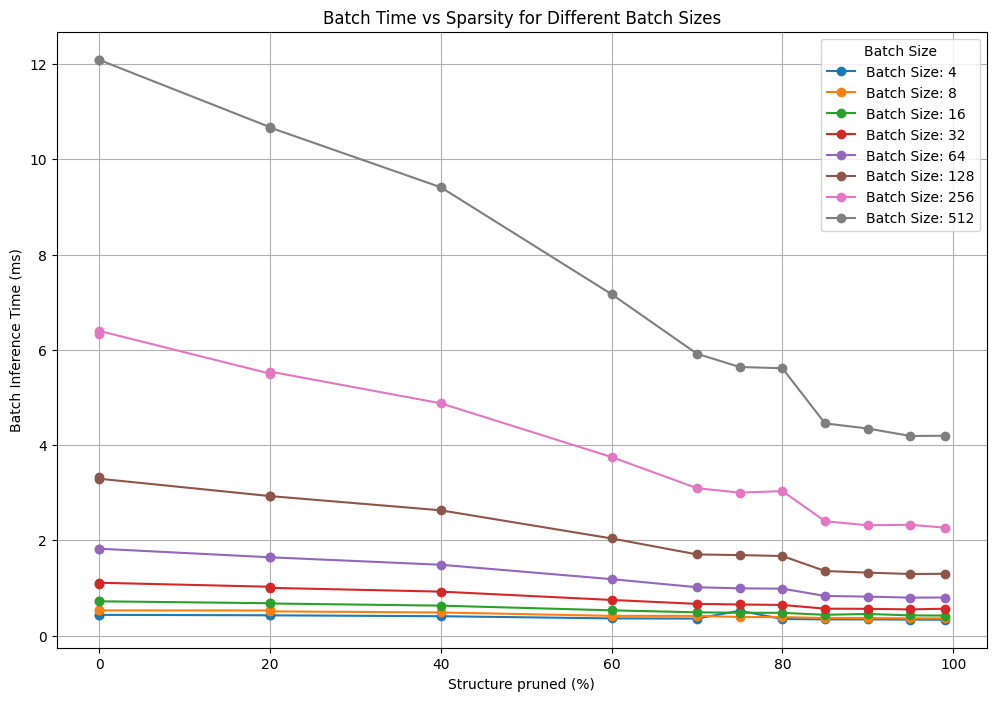

In [516]:
df_flattened = pd.DataFrame(flattened_data)
df_sorted = df_flattened.sort_values(by='Sparsity')

# Plotting with the sorted sparsity values
plt.figure(figsize=(12, 8))
for batch_size in batchsizes:
    batch_data = df_sorted[df_sorted['Batch Size'] == batch_size]
    plt.plot(batch_data['Sparsity'], batch_data['Batch Time'], marker='o', label=f'Batch Size: {batch_size}')

plt.xlabel('Structure pruned (%)')
plt.ylabel('Batch Inference Time (ms)')
plt.title('Batch Time vs Sparsity for Different Batch Sizes')
plt.legend(title='Batch Size')
plt.grid(True)
plt.savefig("lenet_fashionmnist_sp_batchspeed_cpu.pdf")
plt.show()

In [511]:
model_size

[245991,
 245991,
 169323,
 15583,
 39723,
 11627,
 27179,
 31595,
 9887,
 20575,
 107219,
 59947]

In [520]:
#sparsity_values =  sparsity_values[2:]

In [521]:
#model_size

[245991, 169323, 15583, 39723, 11627, 27179, 31595, 9887, 20575, 107219, 59947]

In [522]:
#model_size 

[245991, 169323, 15583, 39723, 11627, 27179, 31595, 9887, 20575, 107219, 59947]

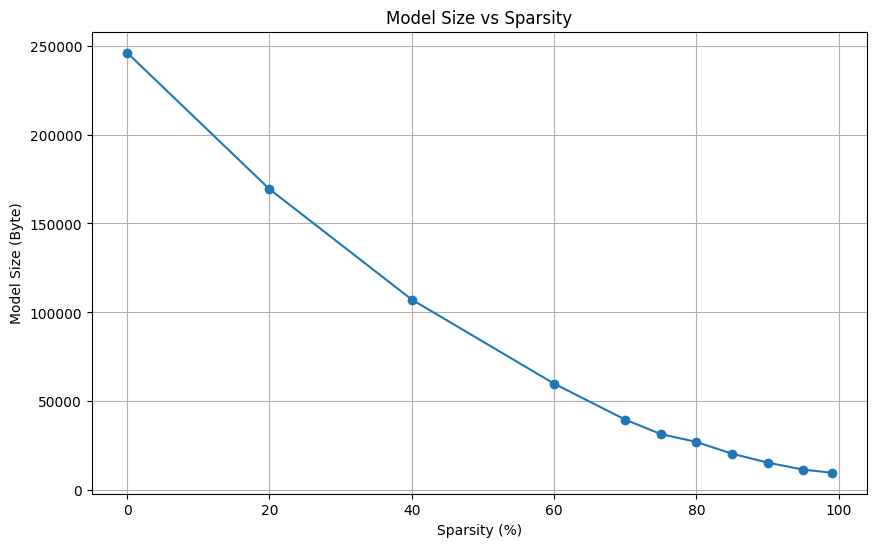

In [523]:
df = pd.DataFrame({
    'Model Size': model_size,
    'Sparsity': sparsity_values
})

# Sorting the DataFrame by 'Sparsity' values
df_sorted = df.sort_values(by='Sparsity')

# Plotting the sorted values
plt.figure(figsize=(10, 6))
plt.plot(df_sorted['Sparsity'], df_sorted['Model Size'], marker='o')
plt.xlabel('Sparsity (%)')
plt.ylabel('Model Size (Byte)')
plt.title('Model Size vs Sparsity')
plt.grid(True)
plt.savefig("lenet_mnist_model_size_n.pdf")
plt.show()


In [528]:
val_ac_lst

[97.21,
 0.9869987964630127,
 97.21,
 0.9865989685058594,
 0.9566994905471802,
 0.9821990132331848,
 0.9194997549057007,
 0.9740989804267883,
 0.9786989688873291,
 0.6719000935554504,
 0.9729989767074585,
 0.983898937702179,
 0.9846988916397095]

In [ ]:
"""loaded_data = torch.load(os.path.join(removed_strture, model_name_new))

# Extract the metadata and state dict
model_metadata = loaded_data['metadata']
state_dict = loaded_data['state_dict']

# Reconstruct the model with the correct architecture
pruned_model = PrunedLeNet(
    n_filters_conv1=model_metadata['n_filters_conv1'],
    n_filters_conv2=model_metadata['n_filters_conv2'],
    n_filters_conv3=model_metadata['n_filters_conv3']
)

# Load the state dict into the model
pruned_model.load_state_dict(state_dict)

# Don't forget to move the model to the appropriate device, if necessary
pruned_model.to(device)"""